Emigration and Socio-Economic Indicators, Statistical Modeling
-----
Author: Luciano Raso [www.lraso.com]

### Business / Policy Question
---

Migration is a high in the political and policy agenda. Can we predict the next migration wave?

### User
---

The analysis has been carried out for the ***[Pacte Lab](https://www.pacte-grenoble.fr/)*** of Grenoble. <br> 
The results are freely accessible, reproducible, and reusable. They can be used, for example, by policy makers of both origin and destination countries.

### Objective
---

__
Identify a predictive model of migration fluxes, based on indicators produced or collected by the World Bank. 
__


Diffrent theories of migration produced different models to explain the flow of people from one location to another. 
See the infographic of the [European Commission](https://ec.europa.eu/knowledge4policy/publication/why-do-people-migrate-infographic_en), or the [scientific literature](https://www.taylorfrancis.com/books/e/9781351926751/chapters/10.4324%2F9781315252001-10).

Here we take an alternative approach: we try to identify a relation between the international data on migration data and  the available socio-economic indicators, collected by the World Bank, aggregated at the country level. We focus initially on emigration data only. <br>

In this notebook I identify a statistical model. A preliminary exploratory data analysis of emigration data and the socio-economic indicators is presented [here](https://github.com/luciofaso/migration_analysis/EDA).

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from IPython.display import Image
import copy

pal = sns.color_palette()
plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

In [151]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

#### Loading Data

In [4]:
data_tot = pd.read_csv('data/emigration_indicators_data.csv')

### Model class selection
Considering the large amount of indicators and the small amount of data, we think that a regularized linear model is the best choice. We select the **lasso** method because it constraints the number of factors used in the model (i.e. with a coefficient $\neq$0). The factors that are not zero can then be interpreted from a socio-economic perspective. 

In [44]:
from sklearn.linear_model import Lasso

### Feature Engineering

As discussed in the [EDA](https://github.com/luciofaso/migration_analysis/blob/master/EmigrationEDA.ipynb) We will work on the log transform of migration data. As regards inputs, we consider bot their original value and their log-transforms for inputs that have positive values. We  keep the intercept, to consider the "independent" flow of migration, i.e. not related to other variables. We use the $log_{10}$ to have a easy-to-interpret output, i.e. a unit of log-transform is a order of magnitude in the original variable. 

We transform both input and output as below:
* Output $y = log_{10} (E)$
* Input used in ther ``raw`` form: $x^R_i = I_i$
* for input with values in $R^+$: $x^L_i = log_{10} (I_i)$ 


so that the model that we identify, here below: 

---
$y = \alpha_0 + \alpha^R_1 \cdot x^R_1 + \alpha^R_2 \cdot x^R_2 + \ldots $  (raw factors)

$+\alpha^L_1 \cdot x^R_1 + x^L_2 \cdot x^R_2  \ldots$ (log factors)



is equivalent to a multiplicative model, as below

___
$E = e ^{\alpha_0} \cdot {I_1}^{\alpha^L_1}\cdot {I_2}^{\alpha^L_2}\cdot \ldots$

$\ldots \cdot \exp (I_i)^{\alpha^R_4} \cdot  \exp(I_i)^{\alpha^R_5} $



### Target selection

One can select here if model on relative emigration (i.e., % of country population) or absolute. This can be done setting variable * absolute * to ``True`` or to ``False``. 

In [5]:
absolute = False

In [6]:
target = 'Log of Emigration, total'
to_drop = 'Log of Emigration, % pop'

if absolute==False:
    target, to_drop = to_drop, target

data_tot = data_tot.drop(['CountryCode','Emigration, % pop','Emigration, total',to_drop],axis=1)
data_tot_ = pd.get_dummies(data_tot)
X,y,input_name = sel_regressor(data_tot_,target)

### Preprocessing

In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from migration_func import sel_regressor

Split the dataset in training and testing

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25)

### Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

Use the training dataset to standardize the input. 

In [46]:
X_train_scaled = scaler.fit_transform(X_train)

### Model Identification

In [47]:
par_range = {'alpha':np.logspace(np.log10(0.9), np.log10(0.0001), num=10)}

lasso_search = GridSearchCV(Lasso(max_iter=10000000), par_range, verbose=1)
lasso_search.fit(X_train_scaled,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   43.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=10000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([9.00000e-01, 3.27252e-01, 1.18993e-01, 4.32675e-02, 1.57326e-02,
       5.72059e-03, 2.08008e-03, 7.56346e-04, 2.75017e-04, 1.00000e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

### Analysis of parameter search

In [10]:
cv_results_df = pd.DataFrame(lasso_search.cv_results_)
cv_results_df = cv_results_df.set_index(cv_results_df['param_alpha'])

/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/lraso/anaconda/lib/python3.5/

[]

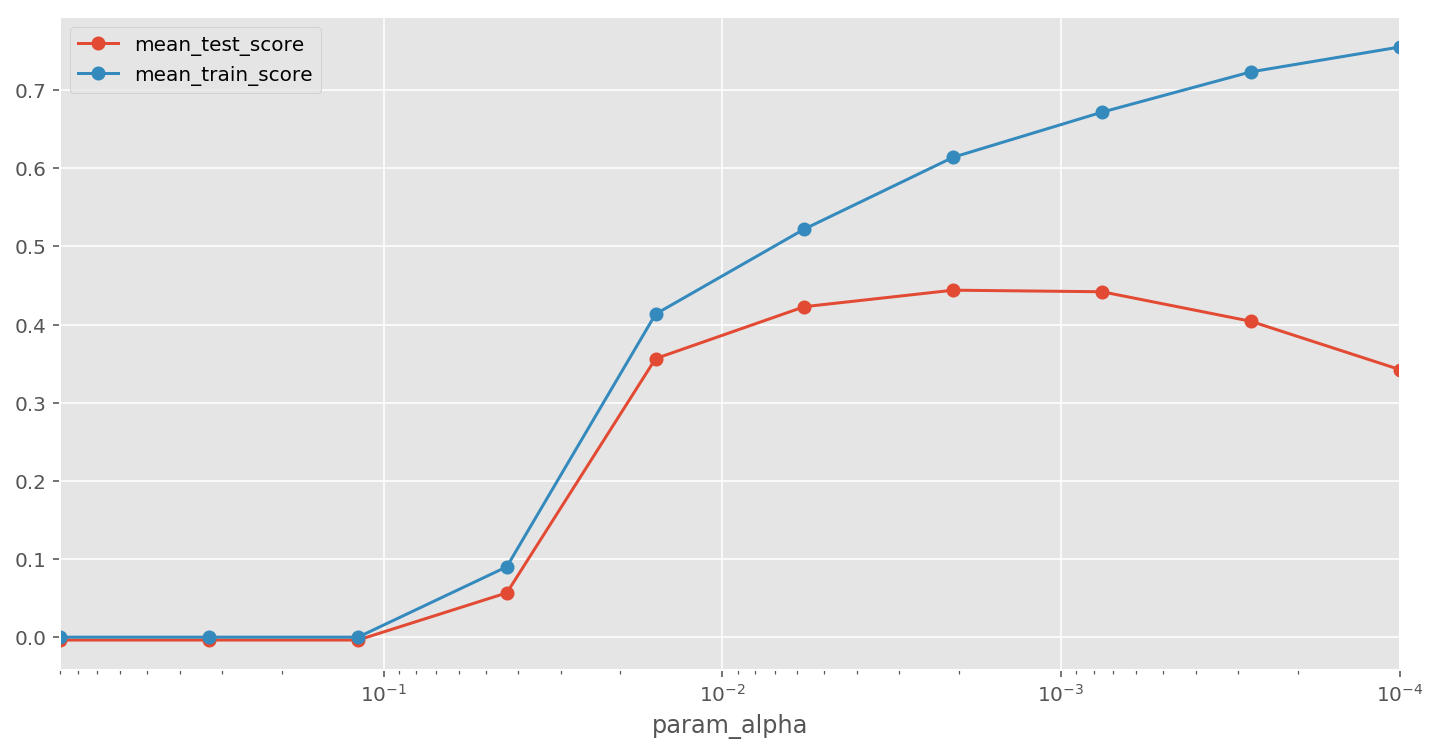

In [11]:
cv_results_df[['mean_test_score','mean_train_score']].plot(marker='o').semilogx()

----
We identify two models:
* **best_lasso**: is the model with the maximum expected performances, i.e. that maximizes the train score.
* **small_lasso**: is a trade-off between maximum performances and parsimoniousness, i.e. smaller number of regressor. 

The reason to identify also the small_lasso model is to have a smaller set of factors, hence a result that will be easier to interpret. 

In [73]:
best_lasso = lasso_search.best_estimator_
best_lasso_coeff_df = pd.Series(best_lasso.coef_,index = input_name).copy()
best_lasso_coeff_df[best_lasso_coeff_df==0] = np.nan
best_lasso_coeff_df = best_lasso_coeff_df.dropna(axis='index')

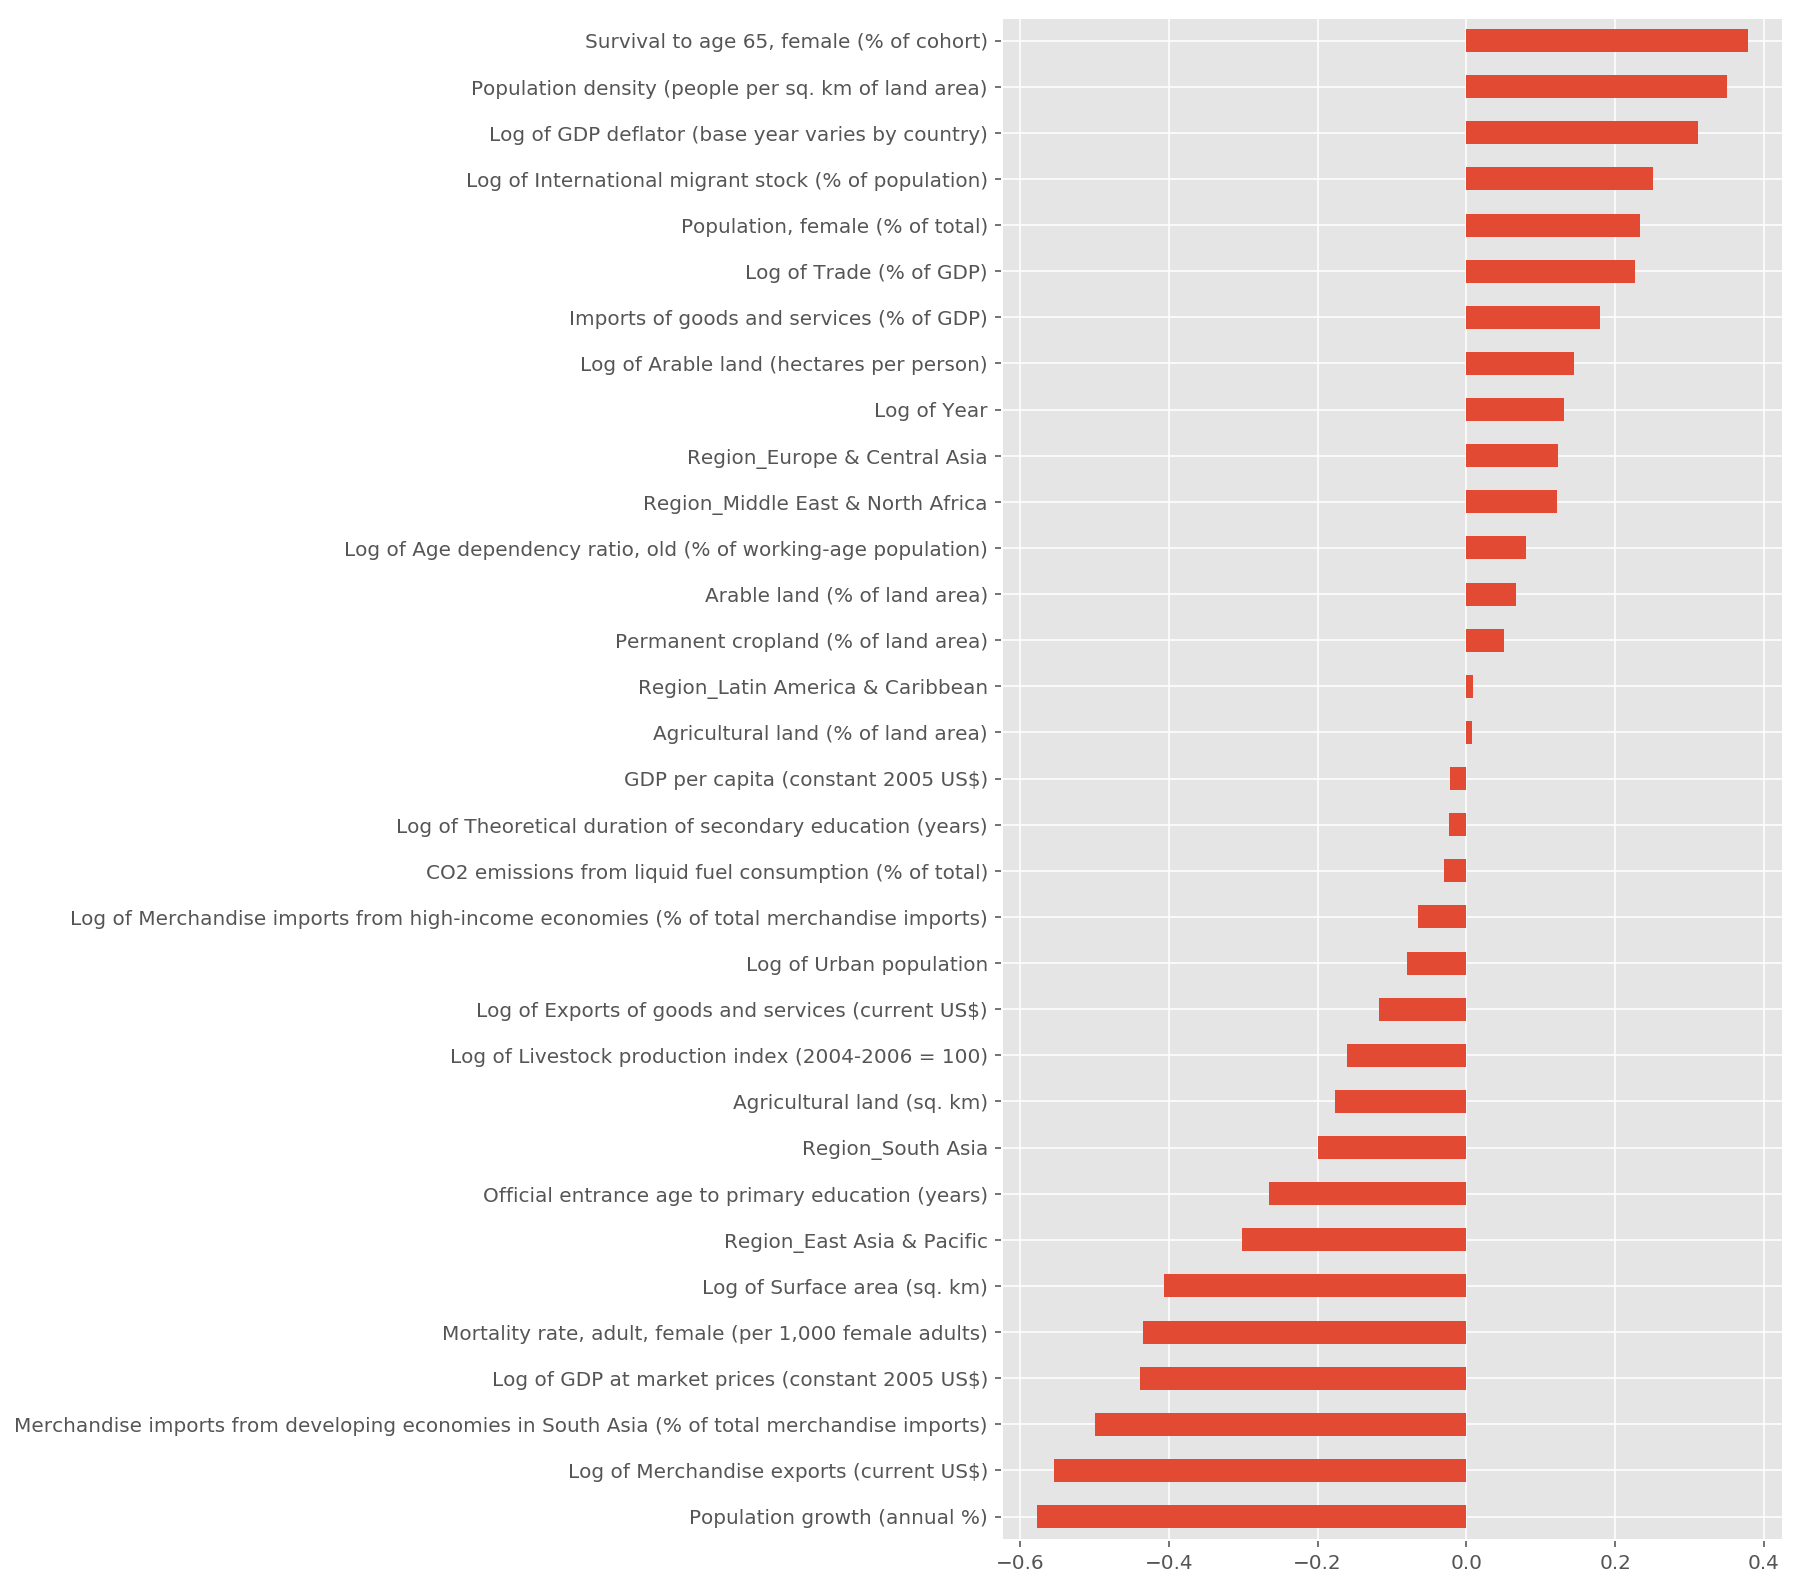

In [74]:
best_lasso_coeff_df.sort_values().plot(kind='barh',figsize=(7,14))

### Parsimonious model

In [75]:
small_lasso = Lasso(alpha=5*10**(-3)).fit(X_train_scaled,y_train)
small_lasso.score(X_train_scaled,y_train)

0.509881318237982

In [76]:
small_lasso_coeff_df = pd.Series(small_lasso.coef_,index = input_name).copy()
small_lasso_coeff_df[small_lasso_coeff_df==0] = np.nan
small_lasso_coeff_df = small_lasso_coeff_df.dropna(axis='index')

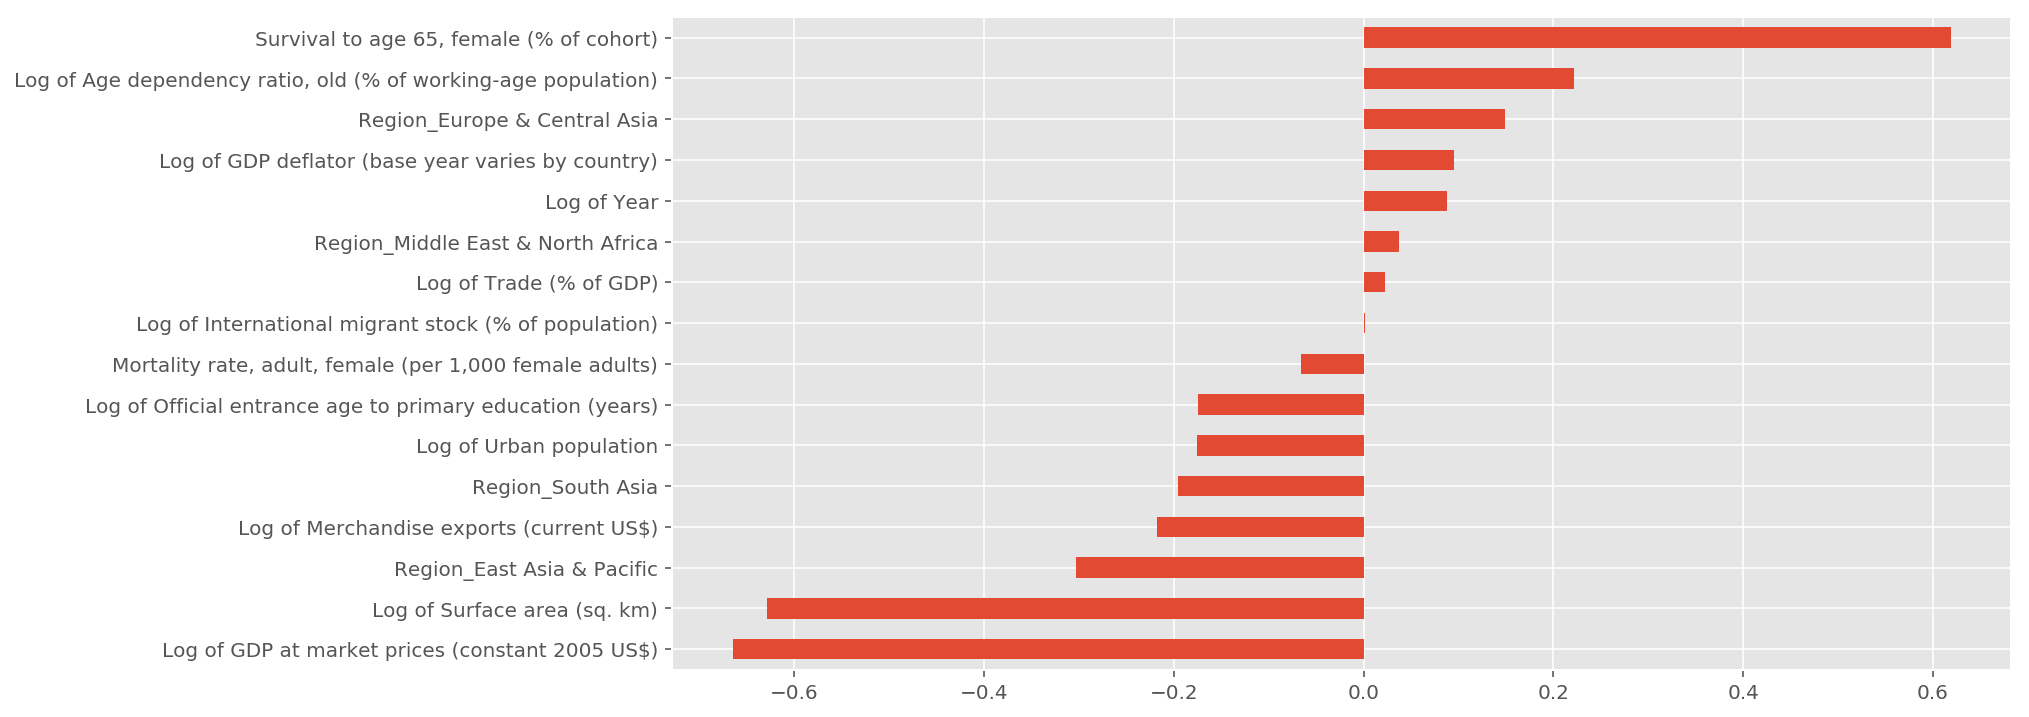

In [77]:
small_lasso_coeff_df.sort_values().plot(kind='barh')

____
TO DO: Comment this

### Single factor effect

Graphical (and numerical) analysis of the effect of each single indicator. 

In [148]:
from migration_func import single_factor_plot

ImportError: cannot import name 'single_factor_plot'

We selected two factor particularly interesting for the ``best`` model: 
* (Annual) Population growth
* (Log of) Trade in & of GDP

<Figure size 1440x360 with 0 Axes>

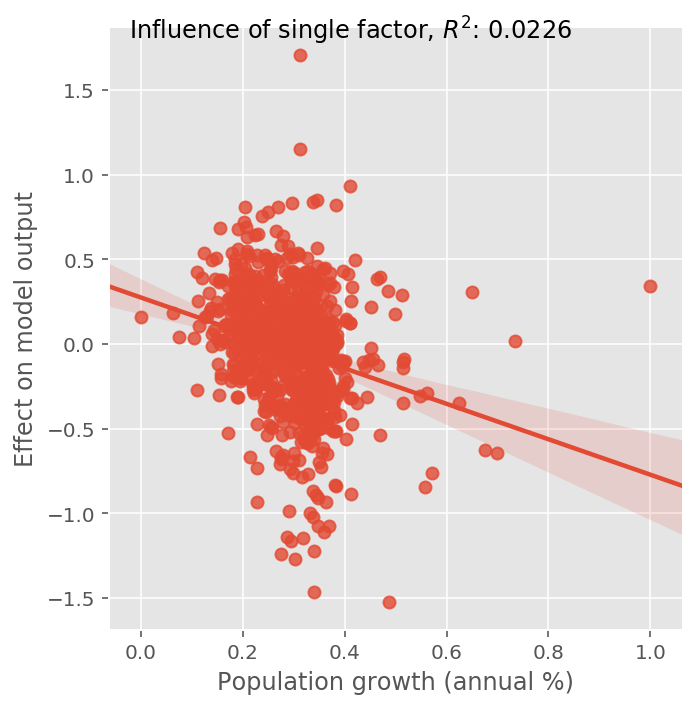

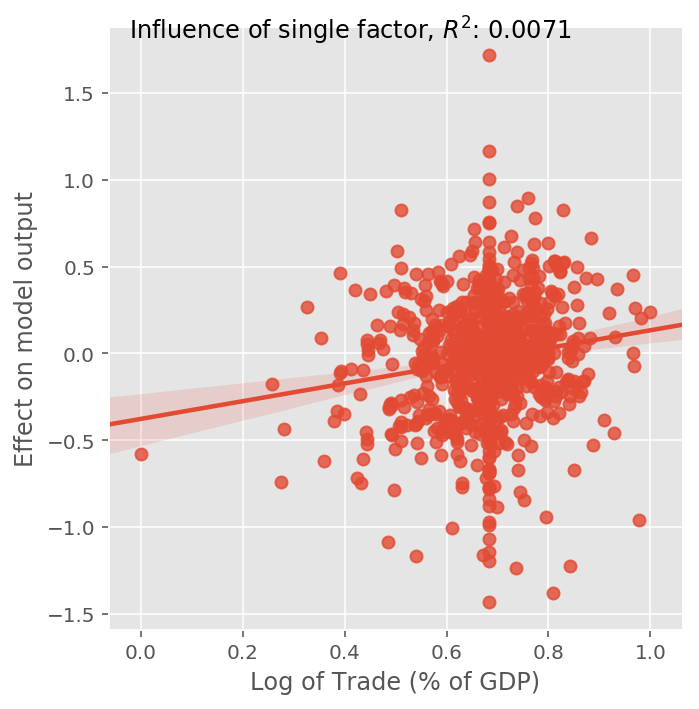

In [152]:
plt.figure(figsize=(20,5))
single_factor_plot('Population growth (annual %)',best_lasso)
single_factor_plot('Log of Trade (% of GDP)',best_lasso)

Similarly, we selected two factor particularly interesting for the ``small`` model: 
* (Log of) Log of GDP at market prices
* Survival to age 65, female

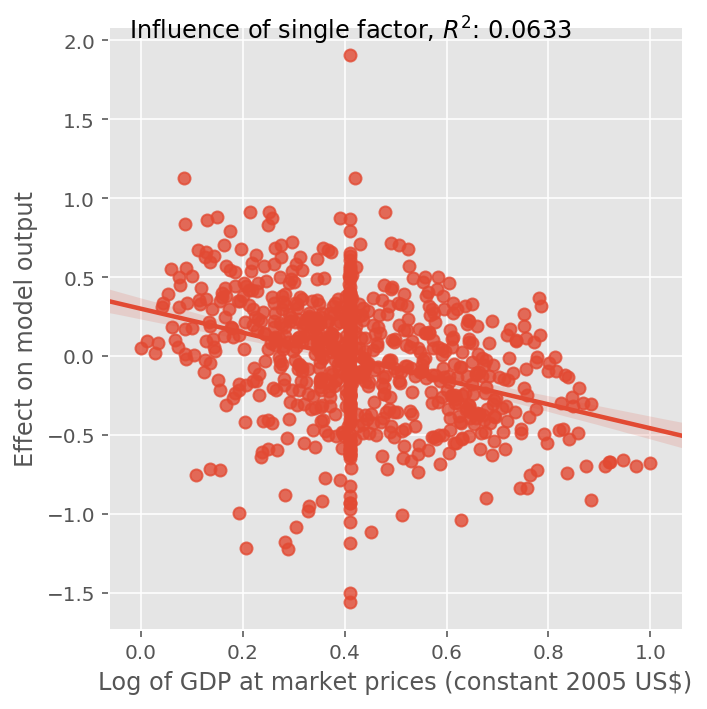

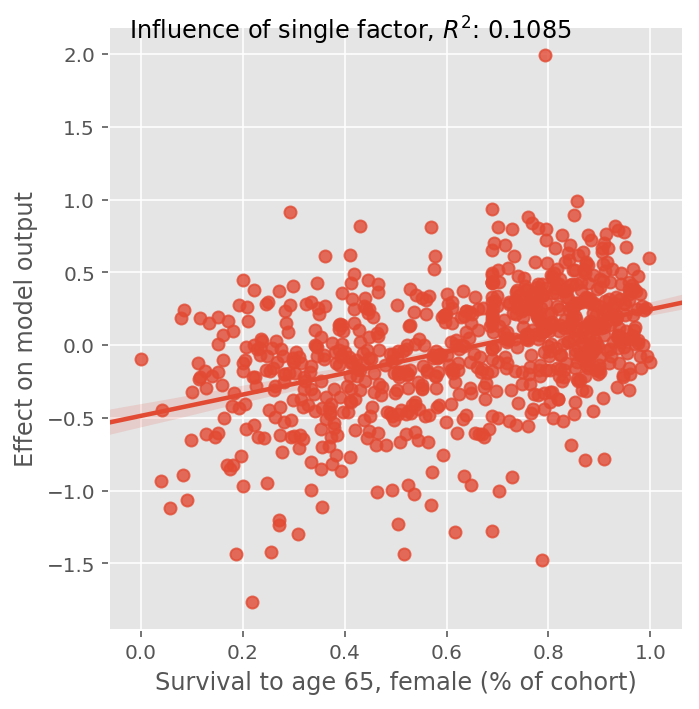

In [154]:
single_factor_plot('Log of GDP at market prices (constant 2005 US$)',small_lasso)
single_factor_plot('Survival to age 65, female (% of cohort)',small_lasso)

----

### Model evaluation

In [33]:
X_test_scaled = scaler.transform(X_test)

In [34]:
best_lasso.score(X_test_scaled, y_test)

0.49692210805759246

In [25]:
y_test_predict = best_lasso.predict(X_test_scaled)

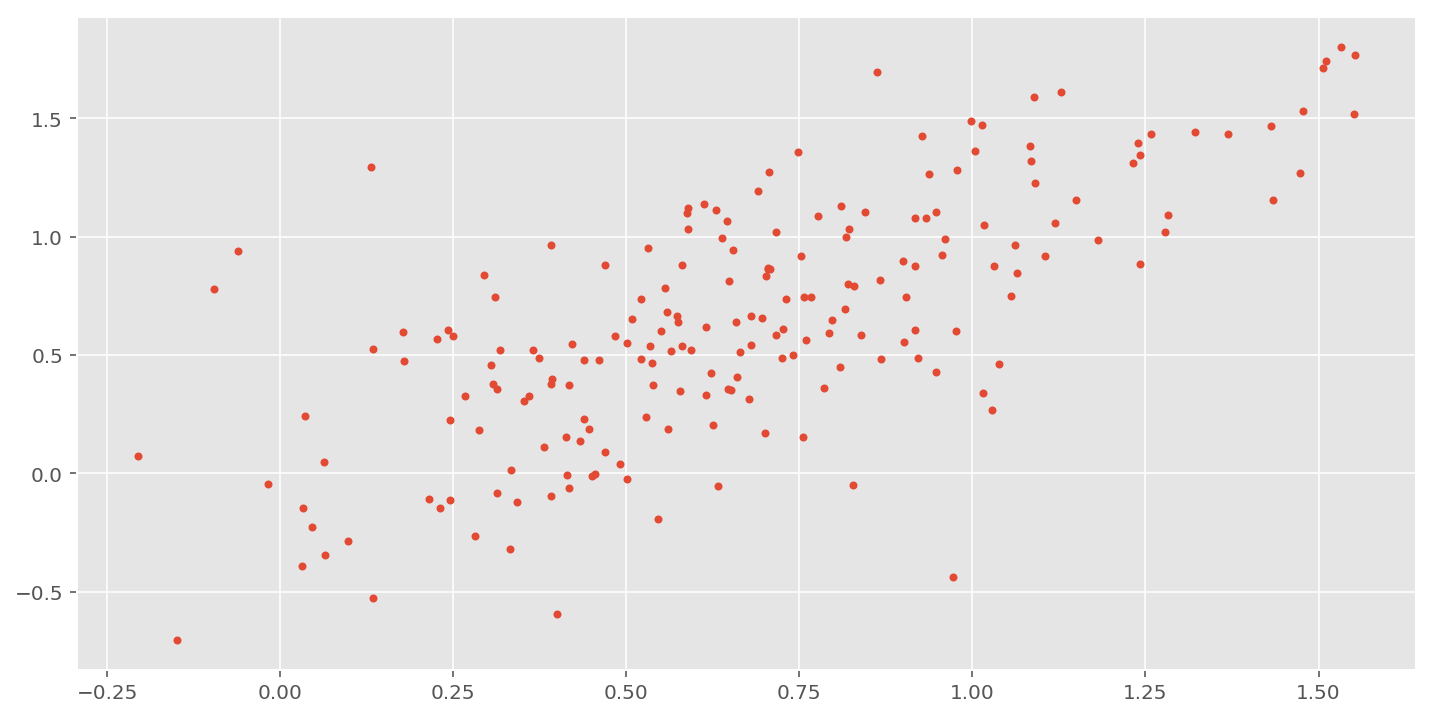

In [29]:
plt.plot(y_test_predict,y_test,'.')

## Conclusions

We can explain about 45% of variation of relative emigration, and 80% of absolute. About 40% explained by population size. 
Range of prediction error about 1 order of magnitude. In line with the objective. Satisfactory. 

Two follow-ups. First: Consider regions. Even if loss of data-points, each region has different process of international migration. Increase the model complexity, either partitioning the data by region, or by use of a non-linear model. <br> 
Second follow up, consider origin and destination. In this analysis we aggregated migration data by country of origin. Large loss of data-points, hence of information. Future analysis can take into account features related to differences or ratios between indicators at origin and destination (example, delta GDP, same region, etc.), relating them with the flow between these two countries.  